## Deep Learning using Resnet 50

In [1]:
#importing libraries
import os
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
#Downloading the CIFAR10 dataset
cifar10=tf.keras.datasets.cifar10

In [3]:
#Downloading and Splitting the CIFAR10 dataset. 
(x_train, y_train), (x_test, y_test)=cifar10.load_data() 

In [4]:
#Defining Class in CIFAR10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
#Display Images with display_images function.
plt.rc('image')
plt.rc('grid', linewidth=0)
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')

def display_images(n,digits, predictions, labels, title):

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(n):
    ax = fig.add_subplot(1, n, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


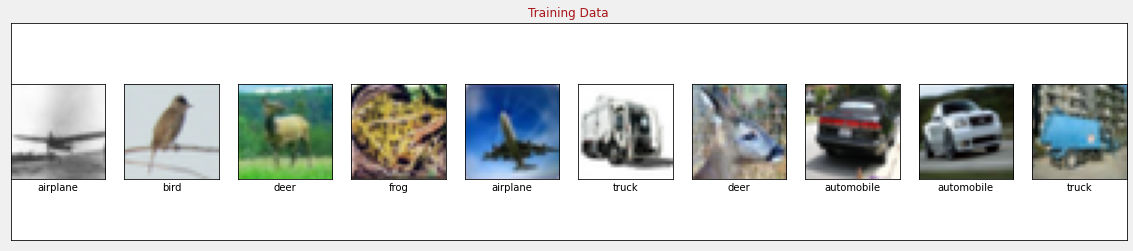

In [6]:
display_images(10,x_train, y_train, y_train, "Training Data" )

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Splitting of the Data

In [8]:
#Splitting the training data into training and validation data
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (40000, 1) (10000, 1)


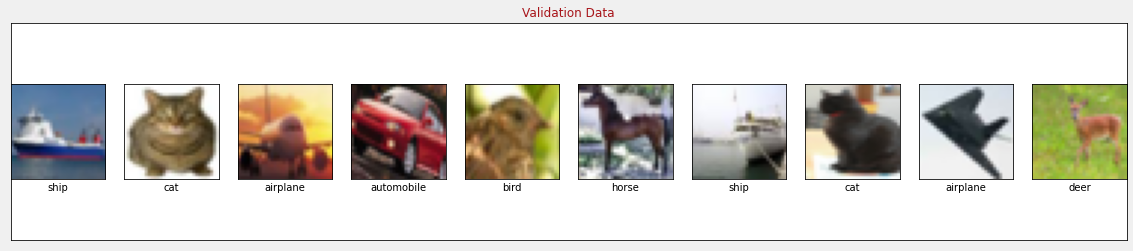

In [74]:
display_images(10,x_valid, y_valid, y_valid, "Validation Data" )

# Image Processing

In [10]:
#Pre-Processing Image with preprocess_input in keras.applications
def preprocess_image(images):
  images = images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(images)
  return output_ims

In [11]:
x_t = preprocess_image(x_train)
x_v = preprocess_image(x_valid)

# Model Training

Defining the Resnet50 model and different layers, on which our model training will be performed.

Since CIFAR10 images have dimensions of 32x32, a resize to 224x224 had to be performed because the Resnet50 requires images of at least 200x200 pixels.

In [12]:
#Define Resnet50 model.
def net_model(inputs):

  net = ResNet50(input_shape=(224, 224, 3),
                          include_top=False,
                          weights='imagenet')(inputs)
  return net
#Define different Keras layers
def classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(.4)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(.2)(x)
    x = Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_extractor = net_model(resize)
    classification = classifier(resnet_extractor)

    return classification

#Final Complie the Model
def compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [13]:
callbacks = [
    EarlyStopping(patience=3,
                  verbose=1),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
                    verbose=1, 
                    save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,
                      patience=2,
                      min_lr=0.001)
]

In [14]:
#Training the Model with different parameters, such as EPoch, Batch_size and Learning_rate.
EPOCHS = 100
history = model.fit(x_t,
                    y_train,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = (x_v, y_valid), 
                    batch_size=32)

Epoch 1/100
1250/1250 [==============================] - 192s 150ms/step - loss: 0.8193 - accuracy: 0.7193 - val_loss: 0.1953 - val_accuracy: 0.9358

Epoch 00001: val_loss improved from inf to 0.19528, saving model to model.01-0.20.h5
Epoch 2/100
1250/1250 [==============================] - 186s 149ms/step - loss: 0.1530 - accuracy: 0.9512 - val_loss: 0.1699 - val_accuracy: 0.9447

Epoch 00002: val_loss improved from 0.19528 to 0.16985, saving model to model.02-0.17.h5
Epoch 3/100
1250/1250 [==============================] - 190s 152ms/step - loss: 0.0741 - accuracy: 0.9762 - val_loss: 0.1843 - val_accuracy: 0.9487

Epoch 00003: val_loss did not improve from 0.16985
Epoch 4/100
1250/1250 [==============================] - 193s 154ms/step - loss: 0.0418 - accuracy: 0.9862 - val_loss: 0.1719 - val_accuracy: 0.9558

Epoch 00004: val_loss did not improve from 0.16985
Epoch 5/100
1250/1250 [==============================] - 194s 155ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.148

# Plotting Training and Validation Loss

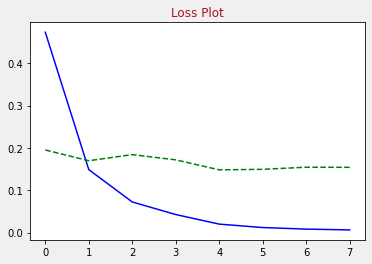

In [15]:
plt.title('Loss Plot')
plt.plot(history.history['loss'],color='blue',label="Training_Loss")
plt.plot(history.history['val_loss'],color='green',linestyle='dashed',label='Validation_Loss')

# Evaluation of the Model on test data

In [16]:
#Evaluate the Model on test data.
x_tes=preprocess_image(x_test)
acc=model.evaluate(x_tes,y_test,batch_size=32)
print("Loss of the Model is:",acc[0])
print("Accuracy of the Model is:",acc[1])

313/313 [==============================] - 17s 53ms/step - loss: 0.1592 - accuracy: 0.9591
Loss of the Model is: 0.1591825634241104
Accuracy of the Model is: 0.9591000080108643


# Testing of the Model

In [17]:
#Testing the Model and check the predicted classes.
probabilities = model.predict(x_tes, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

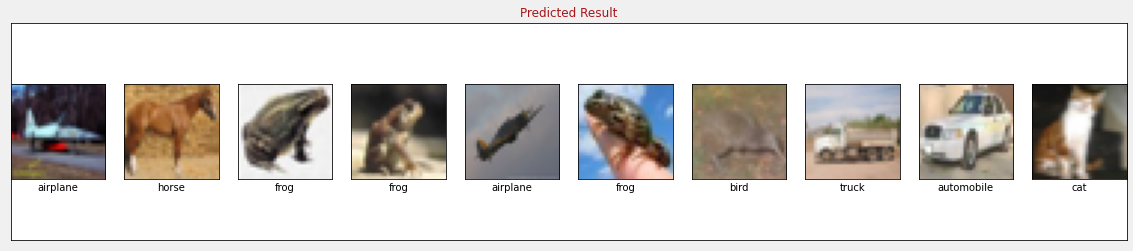

In [18]:
display_images(10,x_test, probabilities, y_test, "Predicted Result")

# Plotting Confusion Matrix

In [19]:
#Calculating Confusion_Matrix
cm=confusion_matrix(y_test, probabilities)

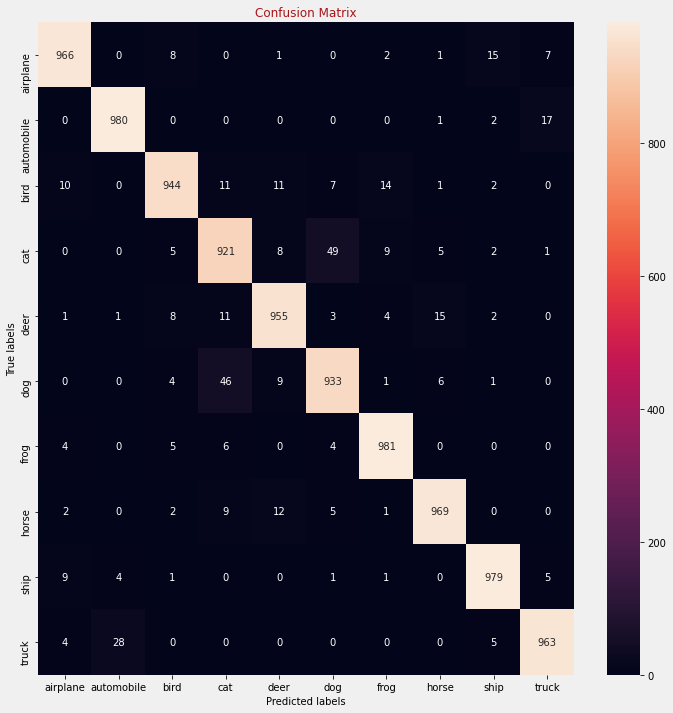

In [34]:
plt.subplots(figsize=(12,12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

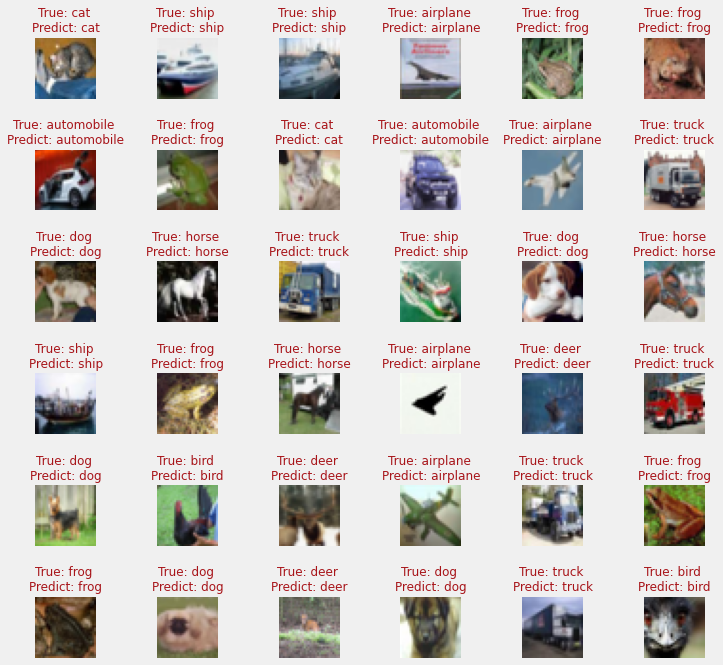

In [71]:
R = 6
C = 6
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i].astype('uint8'), cmap = plt.cm.bone)
    #axes[i].set_title("True: %s \nPredict: %s" % (classes[y_test[i]], classes[probabilities[i]]))
    axes[i].set_title(f"True: {classes[int(y_test[i])]} \nPredict: {classes[int(probabilities[i])]}")
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)
plt.show()

## References

[1] GitHub. 2021. shoji9x9/CIFAR-10-By-small-ResNet. [online] Available at: <https://github.com/shoji9x9/CIFAR-10-By-small-ResNet>.

[2] Team, K., 2021. Keras documentation: ResNet and ResNetV2. [online] Keras.io. Available at: <https://keras.io/api/applications/resnet/#resnet50-function>.

[3] Kaggle.com. 2021. ResNet50 Transfer Learning CIFAR-10 Beginner. [online] Available at: <https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner>.